In [1]:
#!pip install seaborn
#!pip install torch torchtext
#!pip install pytorch-forecasting
#!pip install transformers[torch]
#!pip install evaluate
#!pip install torchtext
!pip list | grep -E 'seaboarn|torch|torchtext|transformers|evaluate'

evaluate                  0.4.1
pytorch-forecasting       1.0.0
pytorch-lightning         2.1.2
pytorch_optimizer         2.12.0
torch                     2.1.1
torchdata                 0.7.1
torchmetrics              1.2.0
torchtext                 0.16.1
transformers              4.35.2

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchtext
from datasets import Dataset
from typing import Optional

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [3]:
def fi2010_df(data):
    all_feature_no = data.shape[1] 
    k = [1,2,3,5,10]
    dict = {}
    for i in range(all_feature_no):
        if i == 50:
            key = 'mid'
        elif i >= 144:
            key = 'horizon%d'%(k[i-144])
        else:
            key = str(i)
        dict[key] = data[:, i]
    df = pd.DataFrame.from_dict(dict)
    return df

In [4]:
dec_data = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Training/Train_Dst_Auction_ZScore_CF_7.txt')
#dec_data = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/3.Auction_DecPre/Auction_DecPre_Training/Train_Dst_Auction_DecPre_CF_7.txt')
dec_data = dec_data.T
dec_test1 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Testing/Test_Dst_Auction_ZScore_CF_7.txt')
dec_test2 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Testing/Test_Dst_Auction_ZScore_CF_8.txt')
dec_test3 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Testing/Test_Dst_Auction_ZScore_CF_9.txt')
#dec_test1 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/3.Auction_DecPre/Auction_DecPre_Testing/Test_Dst_Auction_DecPre_CF_7.txt')
#dec_test2 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/3.Auction_DecPre/Auction_DecPre_Testing/Test_Dst_Auction_DecPre_CF_8.txt')
#dec_test3 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/3.Auction_DecPre/Auction_DecPre_Testing/Test_Dst_Auction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))
dec_test = dec_test.T

In [5]:
dec_data[:, 144:] = dec_data[:,144:] - 1
dec_df = fi2010_df(dec_data)
n = len(dec_df)
train_df = dec_df[0:int(n*0.8)]
val_df = dec_df[int(n*0.8):]
dec_test[:, 144:] = dec_test[:,144:] - 1
test_df = fi2010_df(dec_test)

In [6]:
df = train_df

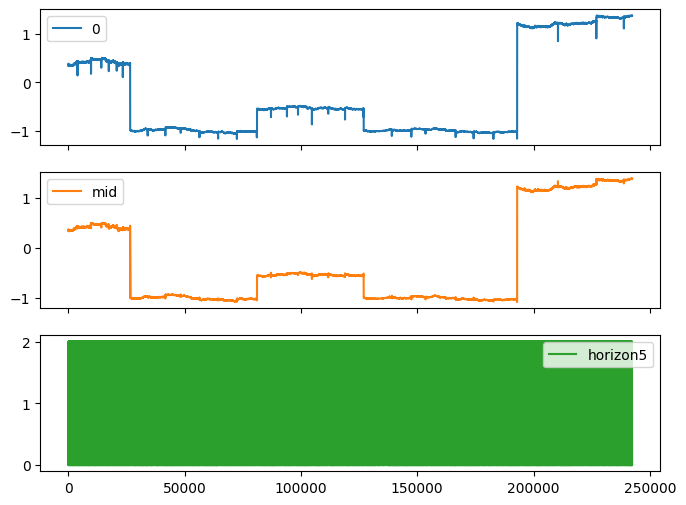

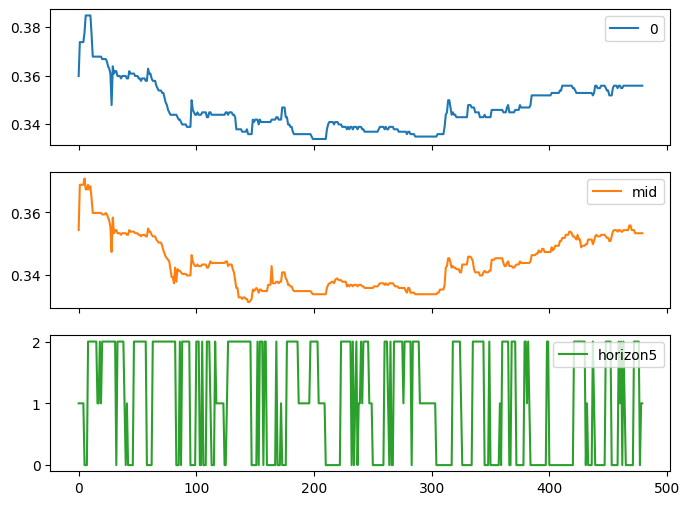

In [7]:
#plot_cols = [c for c in df.columns]
plot_cols = ['0', 'mid', 'horizon5']
plot_features = df[plot_cols]
#plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
#plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,242360.0,-0.301517,0.891396,-1.169331,-1.004744,-0.566843,0.420678,1.379272
1,242360.0,0.092329,1.085704,-0.692396,-0.510077,-0.250928,0.374687,39.392114
2,242360.0,-0.301521,0.891384,-1.064060,-1.005109,-0.565476,0.417704,1.616703
3,242360.0,0.114910,1.078039,-0.687592,-0.513582,-0.237727,0.393715,34.230837
4,242360.0,-0.301508,0.891419,-1.162521,-1.004954,-0.567157,0.421126,1.378495
...,...,...,...,...,...,...,...,...
horizon1,242360.0,1.001774,0.586078,0.000000,1.000000,1.000000,1.000000,2.000000
horizon2,242360.0,1.001510,0.685874,0.000000,1.000000,1.000000,1.000000,2.000000
horizon3,242360.0,1.000656,0.750368,0.000000,0.000000,1.000000,2.000000,2.000000
horizon5,242360.0,0.998288,0.824286,0.000000,0.000000,1.000000,2.000000,2.000000


In [9]:
column_indices = {name: i for i, name in enumerate(df.columns)}

#num_features = df.shape[1]

In [10]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [11]:
train_mean

0           -0.301517
1            0.092329
2           -0.301521
3            0.114910
4           -0.301508
               ...   
horizon1     1.001774
horizon2     1.001510
horizon3     1.000656
horizon5     0.998288
horizon10    0.996670
Length: 149, dtype: float64

In [12]:
df

,0,1,2,3,4,5,6,7,8,9,...,139,140,141,142,143,horizon1,horizon2,horizon3,horizon5,horizon10
0,0.359831,-0.453979,0.348761,-0.302326,0.370266,-0.783942,0.349329,-0.502397,0.388789,-0.783262,...,-0.835445,-0.222202,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1,0.373796,-0.675932,0.363749,-0.571779,0.390211,-0.710027,0.350328,-0.102486,0.389786,-0.647635,...,0.460177,0.449031,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
2,0.373796,-0.675932,0.363749,-0.571779,0.390211,-0.710027,0.350328,-0.102486,0.389786,-0.647635,...,0.733296,0.721681,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
3,0.373796,-0.675932,0.363749,-0.571779,0.390211,-0.447279,0.351328,-0.650695,0.389786,-0.647635,...,1.880904,1.867321,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
4,0.373796,-0.675932,0.363749,-0.571779,0.376250,-0.745096,0.363321,-0.604228,0.388789,-0.783262,...,0.684822,0.673290,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242355,1.374285,-0.510077,1.376904,-0.490303,1.377497,-0.739701,1.377796,-0.532056,1.377817,-0.748849,...,-0.174833,1.059445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
242356,1.375282,-0.321661,1.376904,-0.490303,1.377497,-0.739701,1.377796,-0.532056,1.377817,-0.748849,...,-0.850006,-0.858906,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
242357,1.375282,-0.321661,1.376904,-0.490303,1.377497,-0.739701,1.377796,-0.532056,1.377817,-0.748849,...,1.123577,1.111293,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
242358,1.375282,-0.321661,1.376904,-0.490303,1.377497,-0.739701,1.377796,-0.532056,1.377817,-0.748849,...,1.019704,1.007598,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


In [43]:
df_std = (df - train_mean) / train_std
df_std = df_std.iloc[:, 0:4]
df_std

,0,1,2,3
0,0.741923,-0.503183,0.729520,-0.387032
1,0.757590,-0.707615,0.746334,-0.636980
2,0.757590,-0.707615,0.746334,-0.636980
3,0.757590,-0.707615,0.746334,-0.636980
4,0.757590,-0.707615,0.746334,-0.636980
...,...,...,...,...
242355,1.879973,-0.554853,1.882943,-0.561402
242356,1.881092,-0.381310,1.882943,-0.561402
242357,1.881092,-0.381310,1.882943,-0.561402
242358,1.881092,-0.381310,1.882943,-0.561402


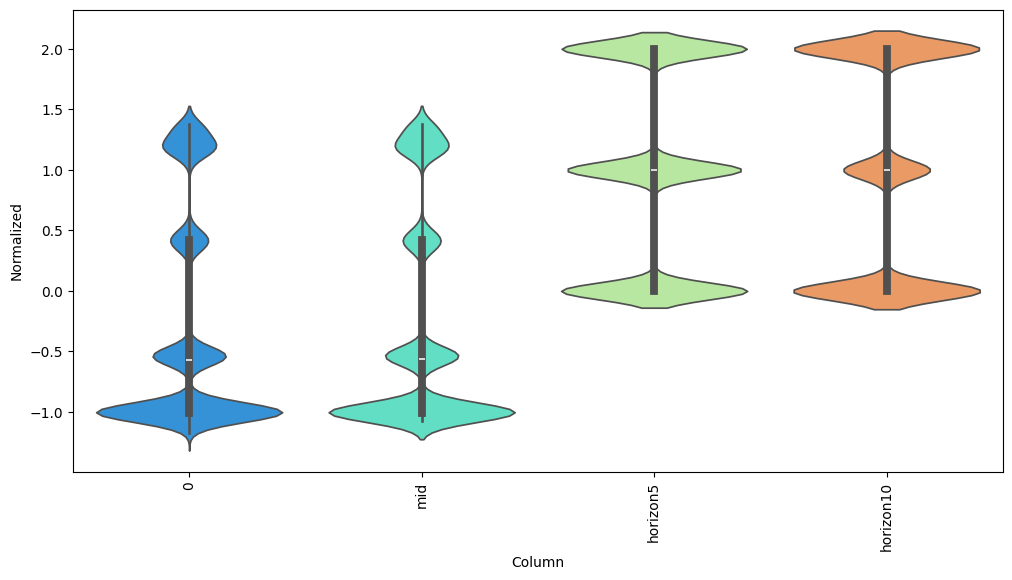

In [13]:
df_std = (df - train_mean) / train_std
df_std = df.iloc[:, [0,50,147,148]]
df_std2 = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std2, palette="rainbow", hue='Column')
ax.set_xticks(ax.get_xticks()) # to avoid warning for set_xticklabels
#_ = ax.set_xticklabels(df.keys(), rotation=90)
_ = ax.set_xticklabels(df_std.keys(), rotation=90)

In [14]:
class TimeseriesDataset(torch.utils.data.Dataset):   
    def __init__(self, data, seq_len, w):
        self.data = data
        self.seq_len = seq_len
        self.w = w # window generator

    def __len__(self):
        return len(self.data) - (self.seq_len-1)

    def __getitem__(self, index):
        features = self.data[index:index+self.seq_len];
        inputs, labels = self.w.split_dataset(features)
        return { 'inputs': inputs, 'labels': labels }

In [16]:
from sklearn.preprocessing import StandardScaler

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df = train_df,
                 val_df = val_df,
                 test_df = test_df,
                 label_columns=['mid']):
        
        self.column_indices = {name: i for i, name in enumerate(df.columns)}

        # Store the raw data.
        #n = len(df)
        #self.train_df = df[0:int(n*0.7)]
        #self.val_df = df[int(n*0.7):int(n*0.9)]
        #self.test_df = df[int(n*0.9):]
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # standardize by training set
        self.train_mean = self.train_df.mean()
        self.train_std = self.train_df.std()

        #def scale_df(df, scaler):
        #    data = scaler.transform(df.values)
        #    return pd.DataFrame(data, index=df.index, columns=df.columns)

        #self.train_df = (self.train_df - self.train_mean)/self.train_std
        #self.val_df = (self.val_df - self.train_mean)/self.train_std
        #self.test_df = (self.test_df - self.train_mean)/self.train_std

        self.num_features = train_df.shape[1]

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                             enumerate(self.train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        self.train = self.make_dataset(self.train_df, shuffle=True)
        self.val = self.make_dataset(self.val_df)
        self.test = self.make_dataset(self.test_df)

    def __repr__(self):
        return '\n'.join([
          f'Total window size: {self.total_window_size}',
          f'Input indices: {self.input_indices}',
          f'Label indices: {self.label_indices}',
          f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
      inputs = features[:, self.input_slice, :]
      labels = features[:, self.labels_slice, :]
      if self.label_columns is not None:
        labels = torch.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
           axis=-1)
    
      return inputs, labels

    def plot(self, model=None, plot_col='mid', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index].cpu(),
                     label='Inputs', marker='.', zorder=-10)
        
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index
        
            if label_col_index is None:
                continue
        
            plt.scatter(self.label_indices, labels[n, :, label_col_index].cpu(),
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model.model(inputs)['pred'].cpu().detach()
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)
        
            if n == 0:
                plt.legend()
      
        plt.xlabel('Time [h]')
    
    def split_dataset(self, features):
        inputs = features[self.input_slice, :]
        labels = features[self.labels_slice, :]
        if self.label_columns is not None:
            labels = np.stack(
                [labels[:, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
      
        return inputs, labels
        

    def make_dataset(self, data, shuffle=False):
        def data_gen(ds):
            for i in range(len(ds)):
                yield(ds[i])
        data = np.array(data, dtype=np.float32)
        tsds = TimeseriesDataset(
            data=data,
            seq_len=self.total_window_size,
            w=self)
        ds = Dataset.from_generator(data_gen, gen_kwargs={'ds': tsds})
        ds = ds.with_format("torch")
        if shuffle:
            ds = ds.shuffle(seed=42)
      
        return ds

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            #result = next(iter(self.train))
            result = self.train[0:32]
            #result = torch.unsqueeze(result['inputs'],0), torch.unsqueeze(result['labels'],0)
            result = result['inputs'].to('cuda'), result['labels'].to('cuda')
            # And cache it for next time
            self._example = result
        return result

    def inverse_transform(self, data):
        #return self.scaler.inverse_transform(data)
        return data*self.train_std + self.train_mean


In [17]:
ts_model_indices = []
for i in range(40):
    ts_model_indices.append(i)
ts_model_indices.append(50)

In [19]:
train_df.iloc[:, ts_model_indices]

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,mid
0,0.741923,-0.503183,0.729520,-0.387032,0.753601,-0.857843,0.730184,-0.594542,0.774338,-0.894296,...,-0.639609,0.860045,-0.483861,0.726390,-0.551526,0.878475,-0.360516,0.707606,-0.304023,0.735753
1,0.757590,-0.707615,0.746334,-0.636980,0.775976,-0.788646,0.731306,-0.221292,0.775456,-0.765539,...,-0.639609,0.881245,-0.347463,0.726390,-0.551526,0.896315,-0.514558,0.707606,-0.304023,0.751993
2,0.757590,-0.707615,0.746334,-0.636980,0.775976,-0.788646,0.731306,-0.221292,0.775456,-0.765539,...,-0.282404,0.881245,-0.347463,0.670161,-0.104346,0.896315,-0.514558,0.668214,-0.464836,0.751993
3,0.757590,-0.707615,0.746334,-0.636980,0.775976,-0.542669,0.732427,-0.732954,0.775456,-0.765539,...,-0.606193,0.860045,-0.483861,0.705023,-0.287401,0.878475,-0.360516,0.672716,-0.151437,0.751993
4,0.757590,-0.707615,0.746334,-0.636980,0.760314,-0.821477,0.745882,-0.689585,0.774338,-0.894296,...,-0.655164,0.860045,-0.483861,0.729764,-0.578785,0.878475,-0.360516,0.728990,-0.524186,0.751993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242355,1.879973,-0.554853,1.882943,-0.561402,1.883520,-0.816426,1.883988,-0.622225,1.883801,-0.861627,...,-0.606193,1.881019,-0.484056,1.875708,-0.551056,1.878619,-0.322254,1.876972,-0.421352,1.881523
242356,1.881092,-0.381310,1.882943,-0.561402,1.883520,-0.816426,1.883988,-0.622225,1.883801,-0.861627,...,-0.577386,1.882135,-0.302451,1.875708,-0.551056,1.880849,-0.451616,1.876972,-0.421352,1.882083
242357,1.881092,-0.381310,1.882943,-0.561402,1.883520,-0.816426,1.883988,-0.622225,1.883801,-0.861627,...,-0.493846,1.882135,-0.302451,1.881331,-0.528027,1.880849,-0.451616,1.879223,-0.523794,1.882083
242358,1.881092,-0.381310,1.882943,-0.561402,1.883520,-0.816426,1.883988,-0.622225,1.883801,-0.861627,...,-0.493846,1.882135,-0.302451,1.881331,-0.551526,1.880849,-0.451616,1.879223,-0.523794,1.882083


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices: [20 21 22 23 24]
Label column name(s): ['mid']

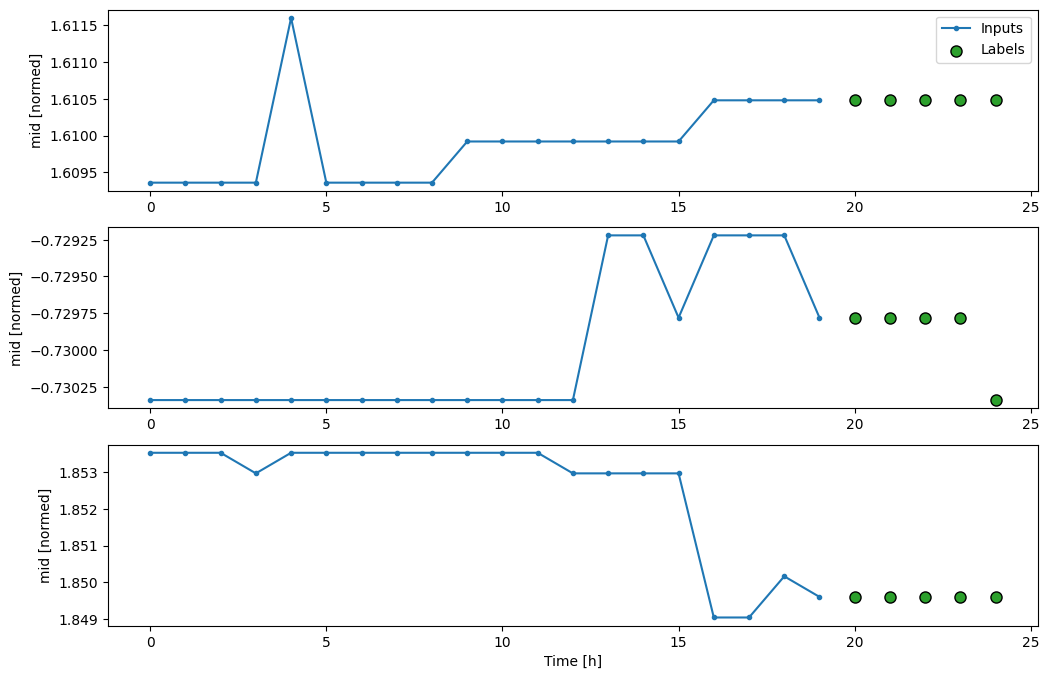

In [20]:
horizon = 5
OUT_STEPS = horizon
multi_window = WindowGenerator(input_width=20,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               train_df=train_df.iloc[:, ts_model_indices],
                               val_df=val_df.iloc[:, ts_model_indices],
                               test_df=test_df.iloc[:, ts_model_indices])

multi_window.plot()
multi_window

In [30]:
num_features = multi_window.num_features

In [21]:
from transformers import TrainingArguments, Trainer
import evaluate
from torchmetrics.regression import MeanAbsoluteError
mean_absolute_error = MeanAbsoluteError()
from transformers import EarlyStoppingCallback

def compute_metrics(evalpred):
    
    preds, labels = evalpred
    preds = torch.Tensor(preds)
    labels = torch.Tensor(labels)
    result = mean_absolute_error(preds, labels)
            
    return {
        "mae" : result
    }

In [22]:
training_args = TrainingArguments(
                    output_dir="test_trainer",
                    num_train_epochs=20,
                    evaluation_strategy = "steps",
                    logging_steps = 0.1,
                    save_steps = 0.1,
                    per_device_train_batch_size = 256,
                    per_device_eval_batch_size = 256,
                    load_best_model_at_end = True,
                    metric_for_best_model = 'eval_loss',
                    greater_is_better = False,
                    learning_rate=0.001,
                    dataloader_num_workers=16,
                    disable_tqdm=False,
                )

In [23]:
class MultiStepLastBaseline(torch.nn.Module):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        self.mse = torch.nn.MSELoss(reduction='none')

    def forward(
        self,
        inputs: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        return_dict: Optional[bool] = None,
    ):
    #def forward(self, inputs, targets, return_loss=True):
        targets = labels
        # last mid values
        y = torch.stack(
            [inputs[:, :, multi_window.column_indices[name]] for name in multi_window.label_columns],
           axis=-1)
        result = torch.tile(y[:, -1:, :], [1, OUT_STEPS, 1])
        if targets is None:
            return {
                'pred': result
            }
        if self.label_index is None:
            return { 
                'loss': torch.mean(self.mse(result, targets),1),
                'pred': result
            }
        if targets is not None:
            loss = torch.mean(self.mse(result, targets), 1)
            return {
                'loss': loss, 
                'pred': result
            }
        else:
            return {
                'pred': result
            }

In [24]:
import transformers
def reset_progress(trainer):
    for callback in trainer.callback_handler.callbacks:
        if isinstance(callback, transformers.utils.notebook.NotebookProgressCallback):
            callback.training_tracker = None
            callback.prediction_bar = None
            callback._force_next_update = False

In [25]:
last_baseline_model = MultiStepLastBaseline()

last_baseline = Trainer(
    model=last_baseline_model,
    args=training_args,
    #train_dataset=single_step_window.val
    #eval_dataset=single_step_window.val,
    #eval_dataset=small_eval_dataset,
    #compute_metrics=mean_absolute_error,
    compute_metrics=compute_metrics
    #data_collator=data_collator,
)

multi_val_performance = {}
multi_performance = {}
multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)['eval_mae']
reset_progress(last_baseline)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test)['eval_mae']

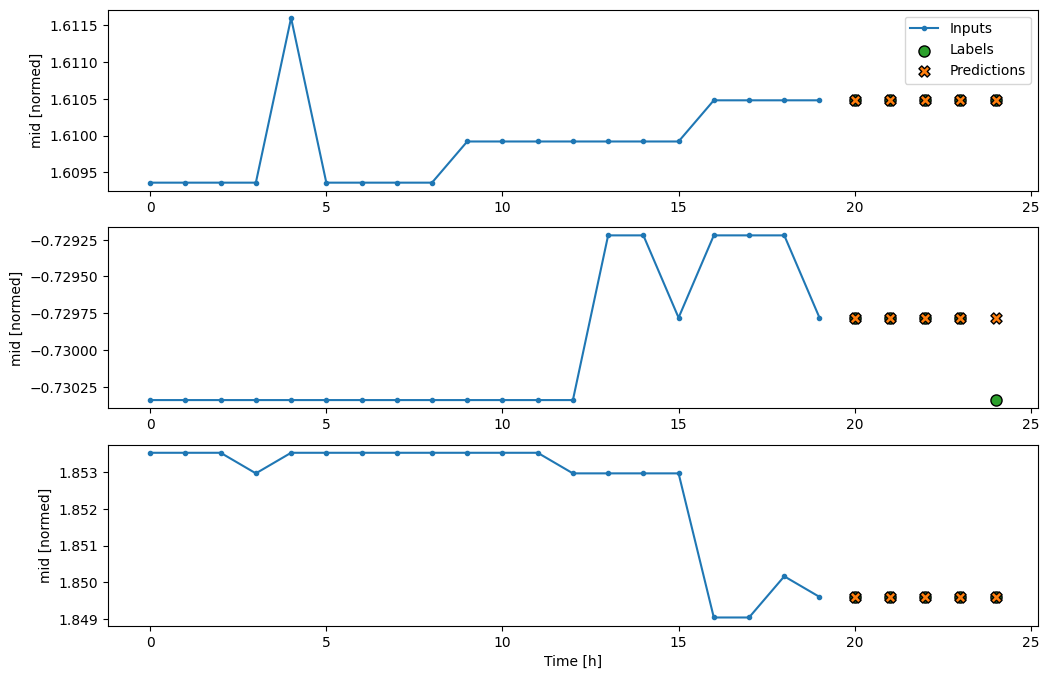

In [26]:
multi_window.plot(last_baseline)

In [27]:
class RepeatBaseline(torch.nn.Module):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        self.mse = torch.nn.MSELoss(reduction='none')

    def forward(
        self,
        inputs: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        return_dict: Optional[bool] = None,
    ):
    #def forward(self, inputs, targets, return_loss=True):
        targets = labels
        n_inputs = int(inputs.shape[1])
        n_targets = OUT_STEPS
        n_tile = n_targets//n_inputs
        n_remain = n_targets%n_inputs
        #result = torch.empty(size=(0, inputs.shape[1], inputs.shape[2]))
        #print('n_tile =', n_tile)
        #print('targets.shape =', targets.shape)
        y = torch.stack([inputs[:, :, multi_window.column_indices[name]] for name in multi_window.label_columns],
                       axis=-1)
        if n_tile > 0:
            result = torch.tile(y[:, :, :], [1, n_tile, 1])
            #result = inputs
        #print('result.shape =', result.shape)
        #print('inputs.shape =', inputs.shape)
        #print('n_tile =', n_tile)
        #print('n_remain =', n_remain)
        if n_remain > 0:
            if n_tile > 0:
                result = torch.cat([result, y[:, 0:n_remain, :]], 1)
            else:
                result = y[:, 0:n_remain, :]
        
        if targets is None:
            return {
                'pred': result
            }
        if self.label_index is None:
            return { 
                'loss': torch.mean(self.mse(result, targets),1),
                'pred': result
            }
        if targets is not None:
            loss = torch.mean(self.mse(result, targets), 1)
            return {
                'loss': loss, 
                'pred': result
            }
        else:
            return {
                'pred': result
            }
repeat_baseline_model = RepeatBaseline()
repeat_baseline = Trainer(
    model=repeat_baseline_model,
    args=training_args,
    #train_dataset=single_step_window.val
    #eval_dataset=single_step_window.val,
    #eval_dataset=small_eval_dataset,
    #compute_metrics=mean_absolute_error,
    compute_metrics=compute_metrics
    #data_collator=data_collator,
)
reset_progress(repeat_baseline)
multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)['eval_mae']
reset_progress(repeat_baseline)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test)['eval_mae']

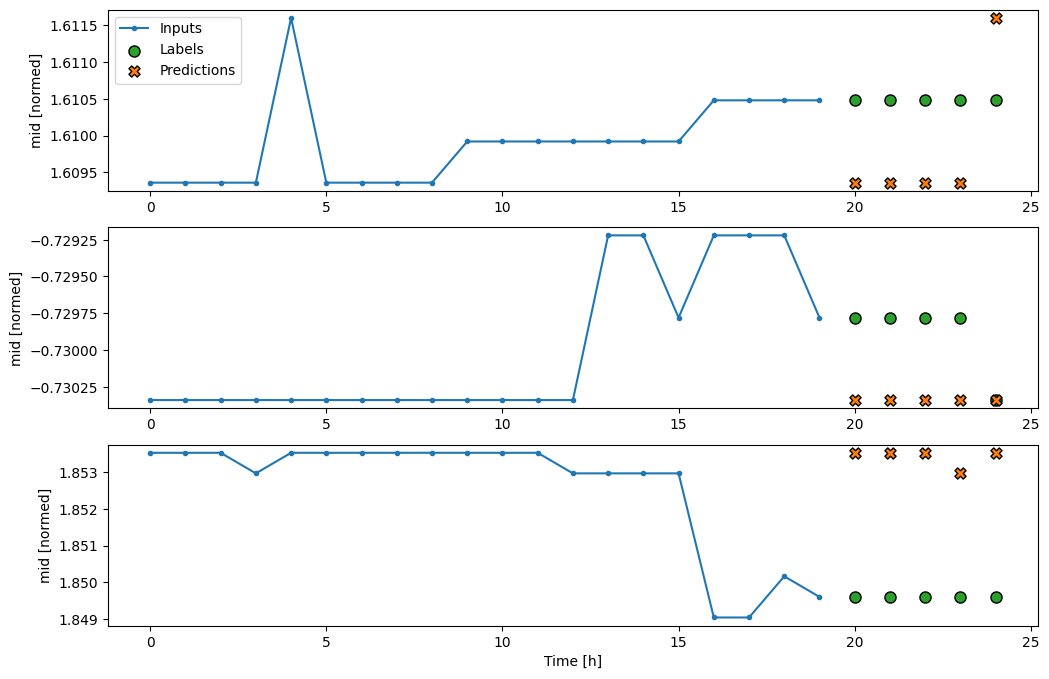

In [28]:
multi_window.plot(repeat_baseline)

In [31]:
class MultiDense(torch.nn.Module):
    def __init__(self, label_index=None, channels=num_features):
        super().__init__()
        self.label_index = label_index
        self.mse = torch.nn.MSELoss(reduction='none')
        if label_index is None:
            self.out_channels = channels
        else:
            self.out_channels = len(label_index)
        self.linear1 = torch.nn.Linear(channels, 512)
        self.linear2 = torch.nn.Linear(512, OUT_STEPS*self.out_channels)
        self.relu = torch.nn.ReLU()

    def forward(
        self,
        inputs: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        return_dict: Optional[bool] = None,
    ):
        targets = labels

        # Take the last time-step.
        # Shape [batch, time, features] => [batch, 1, features]
        x = inputs[:, -1, :]
        
        # Shape => [batch, 1, dense_units]
        x = self.linear1(x)
        x = self.relu(x)
        
        # Shape => [batch, out_steps*features]
        x = self.linear2(x)
        
        # Shape => [batch, out_steps, features]
        result = x.reshape((-1, OUT_STEPS, self.out_channels))
        
        # https://sparrow.dev/adding-a-dimension-to-a-tensor-in-pytorch/
        if targets is not None:
            loss = torch.mean(self.mse(result, targets), 1)
            return {
                'loss': loss, 
                'pred': result
            }
        else:
            return {
                'pred': result
            }
            
multi_dense_model = MultiDense(label_index=['mid'], channels=multi_window.num_features)

multi_dense = Trainer(
    model=multi_dense_model,
    args=training_args,
    #train_dataset=single_step_window.val
    #eval_dataset=single_step_window.val,
    #eval_dataset=small_eval_dataset,
    #compute_metrics=mean_absolute_error,
    compute_metrics=compute_metrics,
    #data_collator=data_collator,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)],
)

In [32]:
%%time
multi_dense.train_dataset = multi_window.train
multi_dense.eval_dataset = multi_window.val

history = multi_dense.train()
print()

Step,Training Loss,Validation Loss,Mae
474,0.009400,0.000039,0.004160
948,0.000300,0.000022,0.002900
1422,0.000300,0.000019,0.002606
1896,0.000200,0.000017,0.002476
2370,0.000200,0.000026,0.003403
2844,0.000200,0.000016,0.002369
3318,0.000200,0.000014,0.002082
3792,0.000200,0.000013,0.001934
4266,0.000100,0.000014,0.002022
4740,0.000100,0.000013,0.001845



CPU times: user 1min 8s, sys: 32.3 s, total: 1min 41s
Wall time: 3min 51s


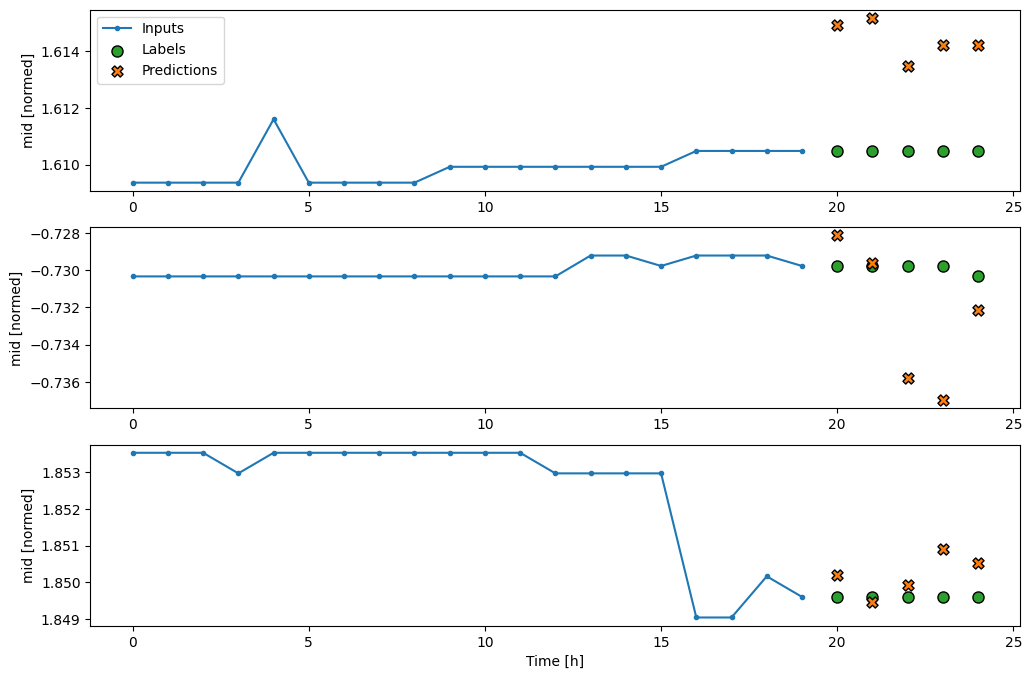

In [33]:
multi_val_performance['Dense'] = multi_dense.evaluate(multi_window.val)['eval_mae']
reset_progress(multi_dense)
multi_performance['Dense'] = multi_dense.evaluate(multi_window.test)['eval_mae']
multi_window.plot(multi_dense)

**TSMixer Pytorch**  
https://github.com/smrfeld/tsmixer-pytorch  
https://github.com/marcopeix/time-series-analysis/blob/master/TSMixer.ipynb  

In [34]:
import torch.nn as nn

class TSBatchNorm2d(nn.Module):

    def __init__(self):
        super(TSBatchNorm2d, self).__init__()
        self.bn = nn.BatchNorm2d(num_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input x: (batch_size, time, features)

        # Reshape input_data to (batch_size, 1, timepoints, features)
        x = x.unsqueeze(1)

        # Forward pass
        output = self.bn(x)

        # Reshape the output back to (batch_size, timepoints, features)
        output = output.squeeze(1)
        return output

class TSTimeMixingResBlock(nn.Module):

    def __init__(self, width_time: int, dropout: float):
        super(TSTimeMixingResBlock, self).__init__()
        self.norm = TSBatchNorm2d()

        self.lin = nn.Linear(in_features=width_time, out_features=width_time)
        self.dropout = nn.Dropout(p=dropout)
        self.act = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input x: (batch_size, time, features)
        y = self.norm(x)
        
        # Now rotate such that shape is (batch_size, features, time)
        y = torch.transpose(y, 1, 2)
        
        # Apply MLP to time dimension
        y = self.lin(y)
        y = self.act(y)

        # Rotate back such that shape is (batch_size, time, features)
        y = torch.transpose(y, 1, 2)

        # Dropout
        y = self.dropout(y)
                
        # Add residual connection
        return x + y


class TSFeatMixingResBlock(nn.Module):

    def __init__(self, width_feats: int, width_feats_hidden: int, dropout: float):
        super(TSFeatMixingResBlock, self).__init__()
        self.norm = TSBatchNorm2d()

        self.lin_1 = nn.Linear(in_features=width_feats, out_features=width_feats_hidden)
        self.lin_2 = nn.Linear(in_features=width_feats_hidden, out_features=width_feats)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)
        self.act = nn.ReLU()


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input x: (batch_size, time, features)
        y = self.norm(x)
        
        # Apply MLP to feat dimension
        y = self.lin_1(y)
        y = self.act(y)
        y = self.dropout_1(y)
        y = self.lin_2(y)
        y = self.dropout_2(y)
                
        # Add residual connection
        return x + y


class TSMixingLayer(nn.Module):

    def __init__(self, input_length: int, no_feats: int, feat_mixing_hidden_channels: int, dropout: float):
        super(TSMixingLayer, self).__init__()
        self.time_mixing = TSTimeMixingResBlock(width_time=input_length, dropout=dropout)
        self.feat_mixing = TSFeatMixingResBlock(width_feats=no_feats, width_feats_hidden=feat_mixing_hidden_channels, dropout=dropout)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input x: (batch_size, time, features)
        y = self.time_mixing(x)
        y = self.feat_mixing(y)
        return y


class TSTemporalProjection(nn.Module):

    def __init__(self, input_length: int, forecast_length: int):
        super(TSTemporalProjection, self).__init__()
        self.lin = nn.Linear(in_features=input_length, out_features=forecast_length)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input x: (batch_size, time, features)
        # Now rotate such that shape is (batch_size, features, time=input_length)
        y = torch.transpose(x, 1, 2)

        # Apply linear projection -> shape is (batch_size, features, time=forecast_length)
        y = self.lin(y)

        # Rotate back such that shape is (batch_size, time=forecast_length, features)
        y = torch.transpose(y, 1, 2)
        return y


class TSMixerModelExclRIN(nn.Module):

    def __init__(self, input_length: int, forecast_length: int, no_feats: int, feat_mixing_hidden_channels: int, no_mixer_layers: int, dropout: float):
        super(TSMixerModelExclRIN, self).__init__()
        self.temp_proj = TSTemporalProjection(input_length=input_length, forecast_length=forecast_length)
        mixer_layers = []
        for _ in range(no_mixer_layers):
            mixer_layers.append(TSMixingLayer(input_length=input_length, no_feats=no_feats, feat_mixing_hidden_channels=feat_mixing_hidden_channels, dropout=dropout))
        self.mixer_layers = nn.ModuleList(mixer_layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input x: (batch_size, time, features)
        for mixer_layer in self.mixer_layers:
            x = mixer_layer(x)

        # Apply temporal projection -> shape is (batch_size, time=forecast_length, features)
        x = self.temp_proj(x)

        return x


class TSMixerModel(nn.Module):
    """Include Reversible instance normalization https://openreview.net/pdf?id=cGDAkQo1C0p
    """    

    def __init__(self, 
                 input_length: int, 
                 forecast_length: int, 
                 no_feats: int, 
                 feat_mixing_hidden_channels: int, 
                 no_mixer_layers: int,  
                 dropout: float, 
                 eps: float = 1e-8):
        super(TSMixerModel, self).__init__()
        self.eps = eps

        # Scale and shift params to learn
        self.scale = nn.Parameter(torch.ones(no_feats))
        self.shift = nn.Parameter(torch.zeros(no_feats))

        # ts mixer layers
        self.ts = TSMixerModelExclRIN(
            input_length=input_length, 
            forecast_length=forecast_length, 
            no_feats=no_feats, 
            feat_mixing_hidden_channels=feat_mixing_hidden_channels,
            no_mixer_layers=no_mixer_layers,
            dropout=dropout
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input x: (batch_size, time, features)

        # Compute mean, var across time dimension
        # mean: (batch_size, 1, features)
        # var: (batch_size, 1, features)
        mean = torch.mean(x, dim=1, keepdim=True)
        var = torch.var(x, dim=1, keepdim=True)

        # Normalize across time dimension
        # x: (batch_size, time, features)
        x = (x - mean) / torch.sqrt(var + self.eps)

        # Apply scale and shift in each feature dimension separately
        # x: (batch_size, time, features)
        # scale: (features)
        # shift: (features)
        x = x * self.scale + self.shift

        # Apply ts mixer layers
        x = self.ts(x)

        # Apply inverse scale and shift in each feature dimension separately
        # x: (batch_size, time, features)
        # scale: (features)
        # shift: (features)
        x = (x - self.shift) / self.scale

        # Unnormalize across time dimension
        # x: (batch_size, time, features)
        # mean: (batch_size, 1, features)
        # var: (batch_size, 1, features)
        x = x * torch.sqrt(var + self.eps) + mean

        return x

In [35]:
class TSMixer(torch.nn.Module):
    def __init__(self,
                 label_index=None, input_length=24, forecast_length=OUT_STEPS,
                 no_feats=19,
                 feat_mixing_hidden_channels=64,
                 no_mixer_layers=8,
                 dropout=0.7):
        super().__init__()

        self.tsmixermodel = TSMixerModel(input_length=input_length,
                                          forecast_length=forecast_length,
                                          no_feats=no_feats, 
                                          feat_mixing_hidden_channels=feat_mixing_hidden_channels,
                                          no_mixer_layers=no_mixer_layers,
                                          dropout=dropout)

        channels = no_feats
        self.label_index = label_index
        self.mse = torch.nn.MSELoss(reduction='none')
        if label_index is None:
            self.out_channels = channels
        else:
            self.out_channels = len(label_index)
        #self.linear1 = torch.nn.Linear(channels, 512)
        #self.linear2 = torch.nn.Linear(512, OUT_STEPS*self.out_channels)
        #self.relu = torch.nn.ReLU()

    def forward(
        self,
        inputs: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        return_dict: Optional[bool] = None,
    ):
        targets = labels

        x = self.tsmixermodel(inputs)
        # last 1 as feature
        # is it right????
        x = x[:, :, -1:]

        result = x
        
        # https://sparrow.dev/adding-a-dimension-to-a-tensor-in-pytorch/
        if targets is not None:
            loss = torch.mean(self.mse(result, targets), 1)
            return {
                'loss': loss, 
                'pred': result
            }
        else:
            return {
                'pred': result
            }
            
tsmixer_model = TSMixer(label_index=['mid'],
                        input_length=multi_window.input_width,
                        forecast_length=OUT_STEPS,
                        no_feats=multi_window.num_features,
                        feat_mixing_hidden_channels=64,
                        no_mixer_layers=8,
                        dropout=0.7)

tsmixer_training_args = TrainingArguments(
                    output_dir="test_trainer",
                    num_train_epochs=30,
                    evaluation_strategy = "steps",
                    logging_steps = 0.1,
                    save_steps = 0.1,
                    per_device_train_batch_size = 32,
                    per_device_eval_batch_size = 256,
                    load_best_model_at_end = True,
                    metric_for_best_model = 'eval_loss',
                    greater_is_better = False,
                    learning_rate=0.0001,
                    disable_tqdm=False,
                    dataloader_num_workers=16,
                )

tsmixer = Trainer(
    model=tsmixer_model,
    args=tsmixer_training_args,
    #train_dataset=single_step_window.val
    #eval_dataset=single_step_window.val,
    #eval_dataset=small_eval_dataset,
    #compute_metrics=mean_absolute_error,
    compute_metrics=compute_metrics,
    #data_collator=data_collator,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)],
)

In [36]:
%%time
tsmixer.train_dataset = multi_window.train
tsmixer.eval_dataset = multi_window.val

history = tsmixer.train()
print()

Step,Training Loss,Validation Loss,Mae
5682,0.000700,0.000011,0.001373
11364,0.000500,0.000010,0.001292
17046,0.000400,0.000009,0.001125
22728,0.000300,0.000008,0.000992
28410,0.000300,0.000007,0.000943
34092,0.000200,0.000007,0.000909
39774,0.000200,0.000007,0.000908
45456,0.000200,0.000007,0.000878
51138,0.000200,0.000007,0.000872
56820,0.000200,0.000007,0.000868



CPU times: user 2h 5min 25s, sys: 11min 3s, total: 2h 16min 28s
Wall time: 1h 14min 11s


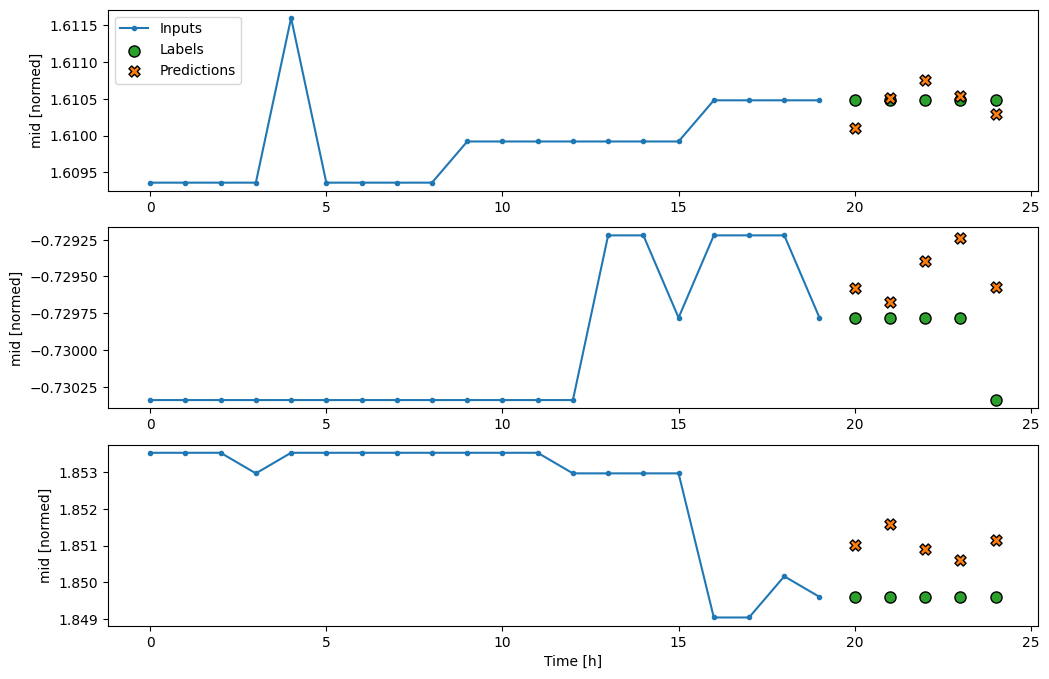

In [37]:
multi_val_performance['TSMixer'] = tsmixer.evaluate(multi_window.val)['eval_mae']
reset_progress(tsmixer)
multi_performance['TSMixer'] = tsmixer.evaluate(multi_window.test)['eval_mae']
multi_window.plot(tsmixer)

In [181]:
#torch.save(tsmixer.model.state_dict(), 'best_model_tsmixer_10_5')
torch.save(tsmixer.model.state_dict(), 'best_model_tsmixer_20_5')

In [37]:
class MultiLstm(torch.nn.Module):
    def __init__(self, label_index=None, channels=19):
        super().__init__()
        self.label_index = label_index
        self.mse = torch.nn.MSELoss(reduction='none')
        hidden_size1 = 512
        self.lstm1 = torch.nn.LSTM(input_size=channels,
                                   hidden_size=hidden_size1,
                                   num_layers=1,
                                   bidirectional=False,
                                   batch_first=True)
        if label_index is None:
            self.out_channels = channels
        else:
            self.out_channels = len(label_index)
        self.linear1 = torch.nn.Linear(hidden_size1, OUT_STEPS*self.out_channels)
        #self.relu = torch.nn.ReLU()

    def forward(
        self,
        inputs: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        return_dict: Optional[bool] = None,
    ):
        targets = labels
        
        # Shape [batch, time, features] => [batch, lstm_units].
        # Adding more `lstm_units` just overfits more quickly.
        x, _ = self.lstm1(inputs)
        x = x[:, -1, :]

        # Shape => [batch, out_steps*features].
        x = self.linear1(x)
        
        # Shape => [batch, out_steps, features]
        result = x.reshape((-1, OUT_STEPS, self.out_channels))
        
        if targets is not None:
            loss = torch.mean(self.mse(result, targets), 1)
            return {
                'loss': loss, 
                'pred': result
            }
        else:
            return {
                'pred': result
            }
multi_lstm_model = MultiLstm(channels=num_features)

multi_lstm = Trainer(
    model=multi_lstm_model,
    args=training_args,
    #train_dataset=single_step_window.val
    #eval_dataset=single_step_window.val,
    #eval_dataset=small_eval_dataset,
    #compute_metrics=mean_absolute_error,
    compute_metrics=compute_metrics,
    #data_collator=data_collator,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)],
)

In [ ]:
def compute_metrics(evalpred):
    
    preds, labels = evalpred
    print('preds.shape =', preds.shape)
    print('labels.shape =', labels.shape)
    preds = torch.Tensor(preds)
    labels = torch.Tensor(labels)
    result = mean_absolute_error(preds, labels)
            
    return {
        "mae" : result
    }

In [38]:
%%time
multi_lstm.train_dataset = multi_window.train
multi_lstm.eval_dataset = multi_window.val

history = multi_lstm.train()
print()

Step,Training Loss,Validation Loss,Mae
184,0.471300,0.597154,0.558835
368,0.326700,0.639588,0.601786
552,0.280300,0.659586,0.587348



CPU times: user 41.2 s, sys: 6.74 s, total: 48 s
Wall time: 1min 16s


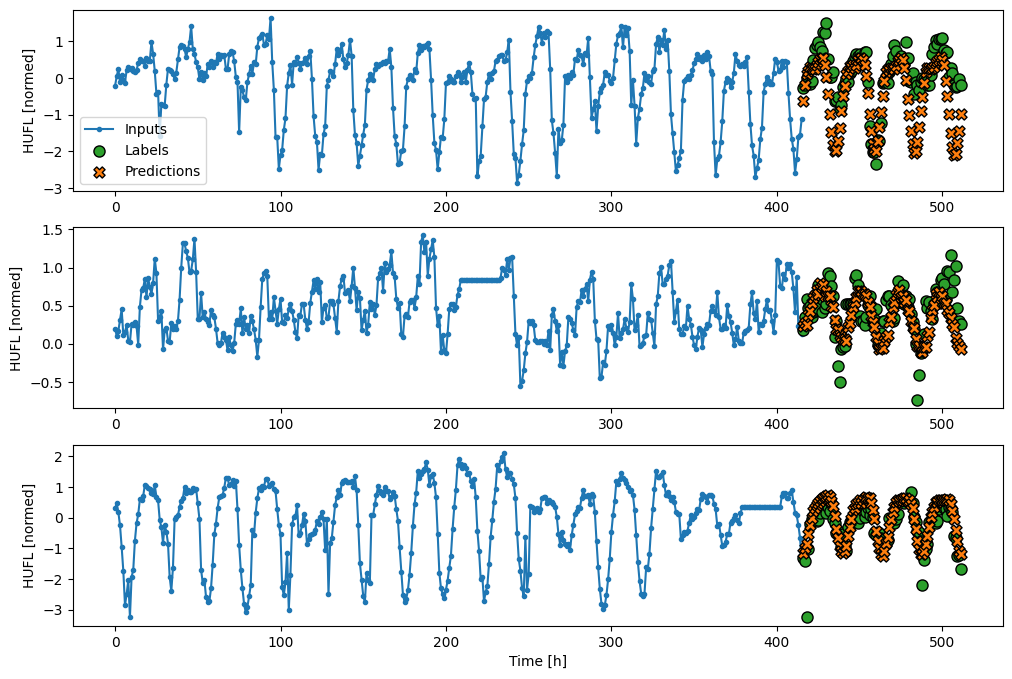

In [39]:
multi_val_performance['LSTM'] = multi_lstm.evaluate(multi_window.val)['eval_mae']
reset_progress(multi_lstm)
multi_performance['LSTM'] = multi_lstm.evaluate(multi_window.test)['eval_mae']
multi_window.plot(multi_lstm)

In [40]:
class MultiGRU(torch.nn.Module):
    def __init__(self, label_index=None, channels=19):
        super().__init__()
        self.label_index = label_index
        self.mse = torch.nn.MSELoss(reduction='none')
        hidden_size1 = 512
        self.gru1 = torch.nn.GRU(input_size=channels,
                                   hidden_size=hidden_size1,
                                   num_layers=2,
                                   bidirectional=False,
                                   dropout=0.5,
                                   batch_first=True)
        if label_index is None:
            self.out_channels = channels
        else:
            self.out_channels = len(label_index)
        self.linear1 = torch.nn.Linear(hidden_size1, OUT_STEPS*self.out_channels)
        #self.relu = torch.nn.ReLU()

    def forward(
        self,
        inputs: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        return_dict: Optional[bool] = None,
    ):
        targets = labels
        
        # Shape [batch, time, features] => [batch, lstm_units].
        # Adding more `lstm_units` just overfits more quickly.
        x, _ = self.gru1(inputs)
        x = x[:, -1, :]

        # Shape => [batch, out_steps*features].
        x = self.linear1(x)
        
        # Shape => [batch, out_steps, features]
        result = x.reshape((-1, OUT_STEPS, self.out_channels))
        
        if targets is not None:
            loss = torch.mean(self.mse(result, targets), 1)
            return {
                'loss': loss, 
                'pred': result
            }
        else:
            return {
                'pred': result
            }
multi_gru_model = MultiGRU(channels=num_features)

multi_gru = Trainer(
    model=multi_gru_model,
    args=training_args,
    #train_dataset=single_step_window.val
    #eval_dataset=single_step_window.val,
    #eval_dataset=small_eval_dataset,
    #compute_metrics=mean_absolute_error,
    compute_metrics=compute_metrics,
    #data_collator=data_collator,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)],
)

In [41]:
%%time
multi_gru.train_dataset = multi_window.train
multi_gru.eval_dataset = multi_window.val

history = multi_gru.train()
print()

Step,Training Loss,Validation Loss,Mae
184,0.414500,0.545888,0.545595
368,0.274200,0.552894,0.549795
552,0.211700,0.659236,0.609850



CPU times: user 1min 8s, sys: 6.85 s, total: 1min 15s
Wall time: 1min 19s


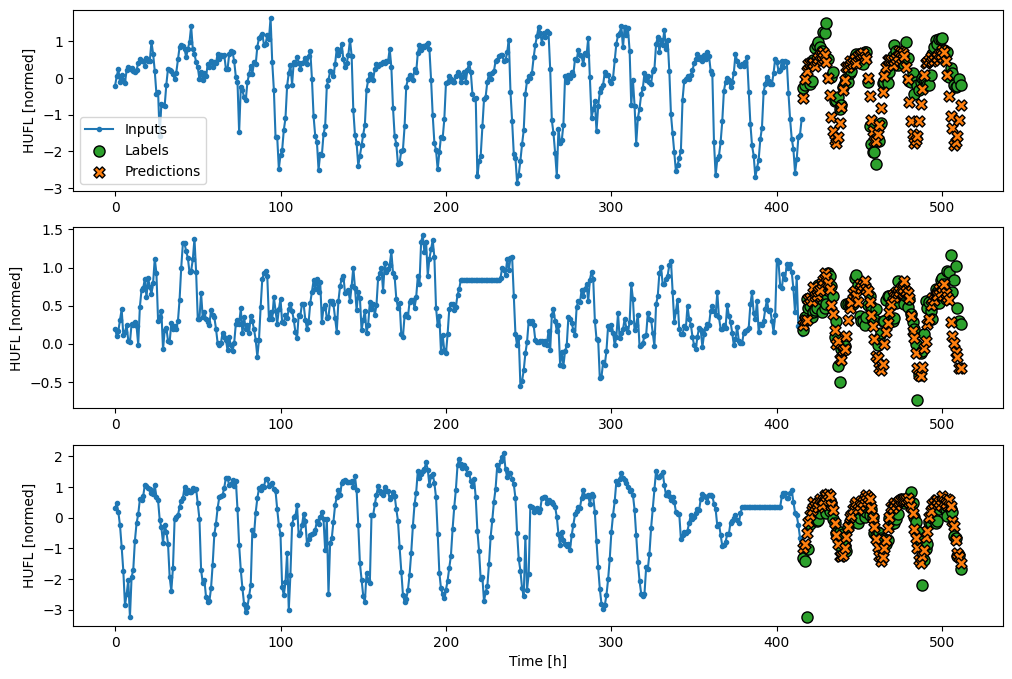

In [42]:
multi_val_performance['GRU'] = multi_gru.evaluate(multi_window.val)['eval_mae']
reset_progress(multi_gru)
multi_performance['GRU'] = multi_gru.evaluate(multi_window.test)['eval_mae']
multi_window.plot(multi_gru)

In [46]:
class FeedBack(torch.nn.Module):
    def __init__(self, units, out_steps, label_index=None, channels=19):
        super().__init__()
        
        if label_index is None:
            self.out_channels = channels
        else:
            self.out_channels = len(label_index)
            
        self.mse = torch.nn.MSELoss(reduction='none')
        
        self.out_steps = out_steps
        self.units = units
        #self.lstm_cell = torch.nn.LSTMCell(channels, units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        #self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.lstm_rnn = torch.nn.LSTM(channels, units, batch_first=True)
        
        #self.dense = tf.keras.layers.Dense(num_features)
        self.dense = torch.nn.Linear(units, self.out_channels)
        #self.relu = torch.nn.ReLU()

    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, 1, lstm_units)
        x, state = self.lstm_rnn(inputs)
        x = x[:, -1:, :]
    
        # predictions.shape => (batch, 1, features)
        prediction = self.dense(x)
        return prediction, state

    def forward(
        self,
        inputs: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        return_dict: Optional[bool] = None,
    ):
        targets = labels

        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        
        # Initialize the LSTM state.
        prediction, state = self.warmup(inputs)
        #print('prediction.shape =', prediction.shape)

        # Insert the first prediction.
        predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_rnn(x, state)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)

        # predictions.shape => (batch, time, features)
        predictions = torch.cat(predictions, dim=1)
        #print('predictions2.shape =', predictions.shape)
        #predictions = torch.permute(predictions, [1, 0, 2])
        
        result = predictions
        
        if targets is not None:
            loss = torch.mean(self.mse(result, targets), 1)
            return {
                'loss': loss, 
                'pred': result
            }
        else:
            return {
                'pred': result
            }
    
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS, channels=num_features)
feedback = Trainer(
    model=feedback_model,
    args=training_args,
    #train_dataset=single_step_window.val
    #eval_dataset=single_step_window.val,
    #eval_dataset=small_eval_dataset,
    #compute_metrics=mean_absolute_error,
    compute_metrics=compute_metrics,
    #data_collator=data_collator,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)],
)

In [47]:
%%time
feedback.train_dataset = multi_window.train
feedback.eval_dataset = multi_window.val

history = feedback.train()
print()

Step,Training Loss,Validation Loss,Mae
184,0.864000,1.190397,0.852327
368,0.737500,1.047757,0.794501
552,0.654100,1.042002,0.798219
736,0.611400,1.061514,0.808252
920,0.592800,1.048990,0.805597



CPU times: user 4min 53s, sys: 25.7 s, total: 5min 19s
Wall time: 2min 47s


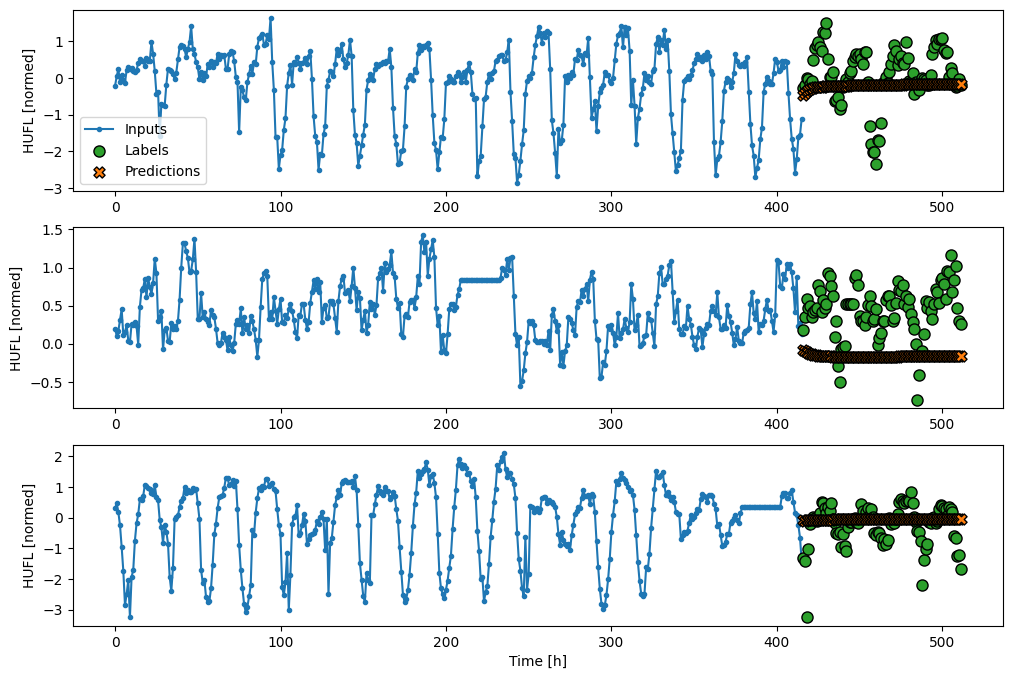

In [48]:
multi_val_performance['AR LSTM'] = feedback.evaluate(multi_window.val)['eval_mae']
reset_progress(feedback)
multi_performance['AR LSTM'] = feedback.evaluate(multi_window.test)['eval_mae']
multi_window.plot(feedback)

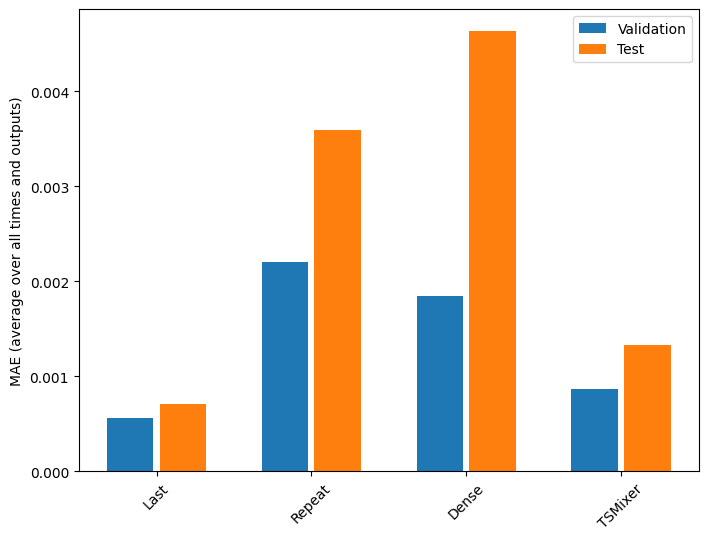

In [38]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
#metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v for v in multi_val_performance.values()]
test_mae = [v for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [50]:
multi_val_performance, multi_performance

({'Last': 0.7404915690422058,
  'Repeat': 0.8866596221923828,
  'Dense': 0.6543939709663391,
  'TSMixer': 0.44245484471321106,
  'LSTM': 0.5588349103927612,
  'GRU': 0.5455954074859619,
  'AR LSTM': 0.7982190251350403},
 {'Last': 0.8438316583633423,
  'Repeat': 1.068686842918396,
  'Dense': 0.6922969222068787,
  'TSMixer': 0.4317578971385956,
  'LSTM': 0.5429388880729675,
  'GRU': 0.5237607955932617,
  'AR LSTM': 0.7679935097694397})

In [51]:
#reset_progress(tsmixer)
outputs = tsmixer.predict(multi_window.test)

In [52]:
predictions, lables, metrics = outputs

In [53]:
scaled_preds = predictions[-1,:,:]

In [54]:
scaled_preds.shape

(96, 7)

In [55]:
cols = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

scaled_preds_df = pd.DataFrame(scaled_preds)
scaled_preds_df.columns = cols

preds_df = multi_window.inverse_transform(scaled_preds_df)

#preds_df = pd.DataFrame(preds)
#preds_df.columns = cols

preds_df.to_csv('data/tsmixer_preds_etth1_h96_torch.csv', index=False, header=True)
scaled_preds_df.to_csv('data/tsmixer_scaled_preds_etth1_h96_torch.csv', index=False, header=True)

In [56]:
scaled_preds_df.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,0.372455,0.287004,0.304574,0.258509,0.027017,0.368747,-1.094129
1,0.461454,0.444646,0.396141,0.379965,0.049568,0.403232,-1.109854
2,0.606578,0.836246,0.531810,0.696016,0.117137,0.484898,-1.149306
3,0.816714,1.187977,0.697927,0.965874,0.429316,0.652010,-1.163099
4,0.909358,1.397948,0.721366,1.118983,0.832888,0.841942,-1.177086


In [57]:
preds_df.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,9.810442,2.563451,6.424771,1.191904,2.948187,1.024754,7.160038
1,10.375700,2.896562,6.988563,1.426027,2.974991,1.047599,7.028748
2,11.297413,3.724044,7.823903,2.035261,3.055304,1.101698,6.699374
3,12.632038,4.467280,8.846712,2.555450,3.426362,1.212400,6.584217
4,13.220442,4.910964,8.991031,2.850590,3.906050,1.338220,6.467443


# Evaluation

In [58]:
nhits_preds = pd.read_csv('data/nhits_preds_etth1_h96.csv')
tsmixer_preds = pd.read_csv('data/tsmixer_preds_etth1_h96_torch.csv')

In [59]:
tsmixer_preds

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,9.810442,2.563451,6.424771,1.191904,2.948187,1.024754,7.160038
1,10.375700,2.896562,6.988563,1.426027,2.974991,1.047599,7.028748
2,11.297413,3.724044,7.823903,2.035261,3.055304,1.101698,6.699374
3,12.632038,4.467280,8.846712,2.555450,3.426362,1.212400,6.584217
4,13.220442,4.910964,8.991031,2.850590,3.906050,1.338220,6.467443
...,...,...,...,...,...,...,...
91,-1.142351,3.604325,-4.125313,1.789620,2.648823,1.369495,8.070565
92,2.423061,3.233772,-0.694536,1.561702,2.804577,1.321190,8.121565
93,5.412261,2.957134,2.139232,1.408035,2.877640,1.234822,8.026142
94,7.761756,2.731031,4.478926,1.269033,2.873941,1.164945,7.919143


In [60]:
df_org = pd.read_csv('data/ETTh1_original.csv')
df_org.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [61]:
#df_org['date'][-96:] = pd.to_datetime(df_org['date'][-96:])
#df_org['date'][:] = pd.to_datetime(df_org['date'][:])
df_org.loc[:, 'date'] = pd.to_datetime(df_org['date'][:])

max_date = df_org['date'][-96:].max()
min_date = df_org['date'][-96:].min()

print(min_date, max_date)

2018-06-22 20:00:00 2018-06-26 19:00:00


In [62]:
df_org.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


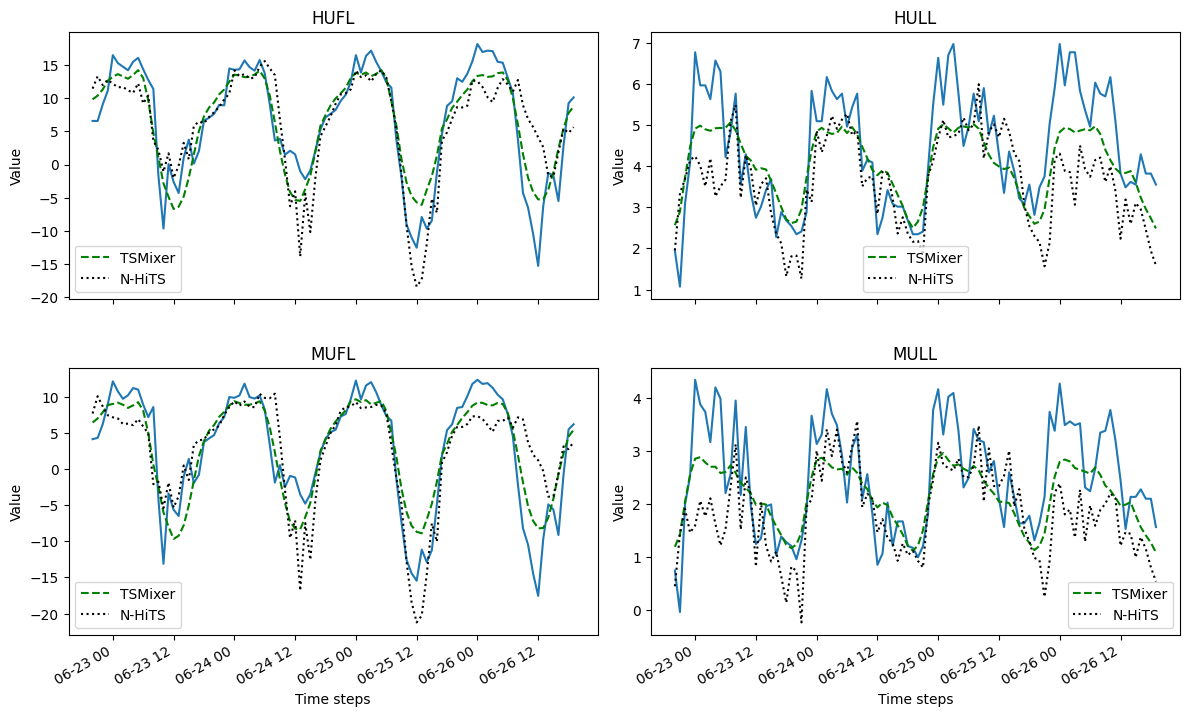

In [65]:
cols_to_plot = ['HUFL', 'HULL', 'MUFL', 'MULL']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

for i, ax in enumerate(axes.flatten()):
    col = cols_to_plot[i]
    
    nhits_df = nhits_preds[nhits_preds['unique_id'] == col] 
    
    ax.plot(df_org['date'][-96:], df_org[col][-96:])
    ax.plot(df_org['date'][-96:], tsmixer_preds[col], label='TSMixer', ls='--', color='green')
    ax.plot(df_org['date'][-96:], nhits_df['NHITS'], label='N-HiTS', ls=':', color='black')
    
    ax.legend(loc='best')
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Value')
    ax.set_title(col)
    
plt.tight_layout()
fig.autofmt_xdate()

In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_actual = df_org.drop('date', axis=1)[-96:]

data = {'N-HiTS': 
            [mean_absolute_error(nhits_preds['y'], nhits_preds['NHITS']), 
             mean_squared_error(nhits_preds['y'], nhits_preds['NHITS'])],
       'TSMixer': 
            [mean_absolute_error(y_actual, tsmixer_preds), 
             mean_squared_error(y_actual, tsmixer_preds)]}

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse']

metrics_df.style.highlight_min(color='lightgreen', axis=1)

,N-HiTS,TSMixer
mae,1.813340,1.273574
mse,9.846109,4.101425
